Prediction model using episodes, genres, source, synopsis, studios, producers

In [1]:
#%pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('Data/training_set.csv')
df.head(10)

,anime_id,title,episodes,score,Popularity_category,Rank_category,Genres_Action,Genres_Adventure,Genres_Avant Garde,Genres_Award Winning,...,producer_pony_canyon,producer_kadokawa,producer_dentsu,producer_fuji_tv,producer_nhk,producer_sotsu,producer_klockworx,producer_kodansha,producer_shueisha,year
0,1,Cowboy Bebop,26.0,9.0,Top 100,Top 100,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1998.0
1,5,Cowboy Bebop: Tengoku no Tobira,1.0,8.0,"Top 1,000",Top 500,True,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2,6,Trigun,26.0,8.0,Top 500,Top 500,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1998.0
3,7,Witch Hunter Robin,26.0,7.0,"Top 2,500","Top 5,000",True,False,False,False,...,False,False,True,False,False,False,False,False,False,2002.0
4,8,Bouken Ou Beet,52.0,7.0,"Top 7,500","Top 5,000",True,False,False,False,...,False,False,True,False,False,False,False,False,False,2004.0
5,15,Eyeshield 21,145.0,8.0,"Top 2,500","Top 1,000",False,False,False,False,...,False,False,False,False,False,False,False,False,True,2005.0
6,16,Hachimitsu to Clover,24.0,8.0,"Top 1,000","Top 1,000",False,False,False,False,...,False,False,True,True,False,False,False,False,True,2005.0
7,17,Hungry Heart: Wild Striker,52.0,8.0,"Top 5,000","Top 2,500",False,False,False,False,...,False,False,False,False,False,False,False,False,False,2002.0
8,18,Initial D Fourth Stage,24.0,8.0,"Top 2,500",Top 500,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2004.0
9,19,Monster,74.0,9.0,Top 500,Top 100,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2004.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21280 entries, 0 to 21279
Columns: 239 entries, anime_id to year
dtypes: bool(79), float64(154), int64(2), object(4)
memory usage: 27.6+ MB


In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [6]:
scaler = preprocessing.MinMaxScaler()
df[["episodes"]] = scaler.fit_transform(df[["episodes"]])

In [7]:
most_common = df["Popularity_category"].value_counts().idxmax()  
df["Popularity_category"] = df["Popularity_category"].replace("Unknown", most_common)

In [8]:
most_common = df["Rank_category"].value_counts().idxmax()  
df["Rank_category"] = df["Rank_category"].replace("Unknown", most_common)
df["Rank_category"] = df["Rank_category"].replace("Top 10", "Top 100")
df["Popularity_category"] = df["Popularity_category"].replace("Top 10", "Top 100")

In [9]:
df['score'] = df['score'].round().astype(int)
df['score'] = df['score'].astype(str)

In [10]:
#X_train = df.drop(columns=["anime_id","title","score", "popularity", "rank", "Popularity_category", "Rank_category", "studios"])
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["anime_id","title","score", "popularity", "rank", "Popularity_category", "Rank_category", "studios", "year"]),
    df[["score", "Popularity_category", "Rank_category"]],
    test_size=0.2, 
    random_state=42  
)


In [11]:
score_encoder = LabelEncoder()
popularity_encoder = LabelEncoder()
rank_encoder = LabelEncoder()

y_score_encoded = score_encoder.fit_transform(y_train['score'])

y_pop_encoded = popularity_encoder.fit_transform(y_train['Popularity_category'])

y_rank_encoded = rank_encoder.fit_transform(y_train['Rank_category'])

In [12]:
y_score = to_categorical(y_score_encoded)

y_pop = to_categorical(y_pop_encoded)

y_rank = to_categorical(y_rank_encoded)

In [13]:
input_layer = Input(shape=(X_train.shape[1],))
hidden_layer = Dense(64, activation='relu')(input_layer)
shared_layer = Dense(64, activation='relu')(input_layer)
shared_layer = Dense(64, activation='relu')(shared_layer)

In [14]:
score_output = Dense(y_score.shape[1], activation='softmax', name="score")(shared_layer)
popularity_output = Dense(y_pop.shape[1], activation='softmax', name="popularity")(shared_layer)
rank_output = Dense(y_rank.shape[1], activation='softmax', name="rank")(shared_layer)

In [15]:
model = Model(inputs=input_layer, outputs=[score_output, popularity_output, rank_output])

model.compile(optimizer='adam',
              loss={'score': 'categorical_crossentropy',
                    'popularity': 'categorical_crossentropy',
                    'rank': 'categorical_crossentropy'},
              metrics={
                  'score': ['accuracy'],
                  'popularity': ['accuracy'], 
                  'rank': ['accuracy']  
                  })

In [16]:
history = model.fit(X_train,
                    {'score': y_score, 'popularity': y_pop, 'rank': y_rank},
                    validation_split=0.2,
                    epochs=50,
                    batch_size=128)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.3951 - popularity_accuracy: 0.3145 - popularity_loss: 1.9857 - rank_accuracy: 0.4142 - rank_loss: 1.7864 - score_accuracy: 0.5111 - score_loss: 1.6229 - val_loss: 3.4949 - val_popularity_accuracy: 0.5366 - val_popularity_loss: 1.2995 - val_rank_accuracy: 0.5621 - val_rank_loss: 1.2068 - val_score_accuracy: 0.6244 - val_score_loss: 0.9902
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3744 - popularity_accuracy: 0.5436 - popularity_loss: 1.2525 - rank_accuracy: 0.5742 - rank_loss: 1.1576 - score_accuracy: 0.6323 - score_loss: 0.9642 - val_loss: 3.1607 - val_popularity_accuracy: 0.5838 - val_popularity_loss: 1.1191 - val_rank_accuracy: 0.5727 - val_rank_loss: 1.1216 - val_score_accuracy: 0.6358 - val_score_loss: 0.9206
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1150 - popularity_accuracy: 0.5679 - popularity_loss: 1.1249 - rank_accuracy: 0.5832 - rank_loss: 1.1001 - score_accuracy: 0.6427 - sc

In [17]:
y_pred = model.predict(X_test)

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


In [18]:
y_pred_score = y_pred[0].argmax(axis=1)
y_pred_score = score_encoder.inverse_transform(y_pred_score)

y_pred_pop = y_pred[1].argmax(axis=1)
y_pred_pop = popularity_encoder.inverse_transform(y_pred_pop)

y_pred_rank = y_pred[2].argmax(axis=1)
y_pred_rank = rank_encoder.inverse_transform(y_pred_rank)

In [19]:
accuracy_score_score = accuracy_score(y_test['score'], y_pred_score)
accuracy_score_pop = accuracy_score(y_test['Popularity_category'], y_pred_pop)
accuracy_score_rank = accuracy_score(y_test['Rank_category'], y_pred_rank)

print(f"Accuracy for Score Prediction: {accuracy_score_score:.4f}")
print(f"Accuracy for Popularity Category Prediction: {accuracy_score_pop:.4f}")
print(f"Accuracy for Rank Category Prediction: {accuracy_score_rank:.4f}")


Accuracy for Score Prediction: 0.6252
Accuracy for Popularity Category Prediction: 0.5813
Accuracy for Rank Category Prediction: 0.5841


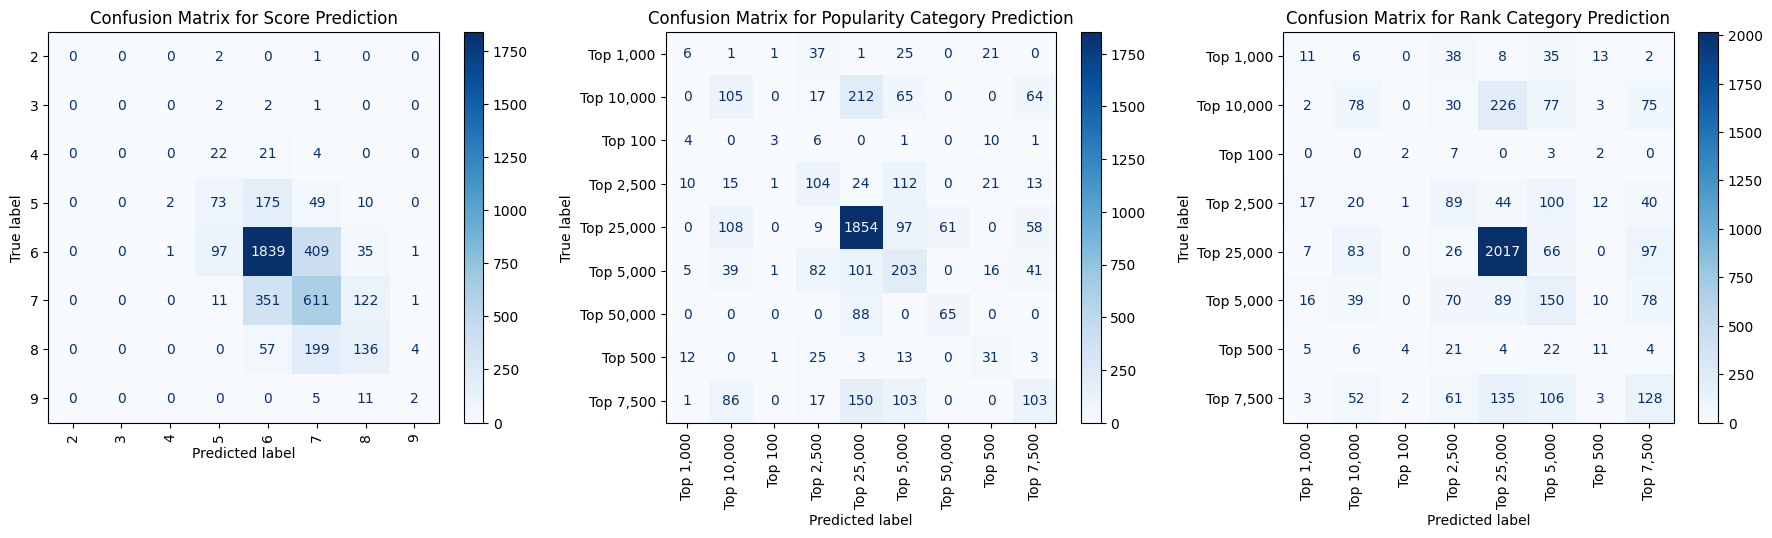

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_score = confusion_matrix(y_test['score'], y_pred_score, labels=score_encoder.classes_)
cm_pop = confusion_matrix(y_test['Popularity_category'], y_pred_pop, labels=popularity_encoder.classes_)
cm_rank = confusion_matrix(y_test['Rank_category'], y_pred_rank, labels=rank_encoder.classes_)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

disp_score = ConfusionMatrixDisplay(confusion_matrix=cm_score, display_labels=score_encoder.classes_)
disp_score.plot(cmap=plt.cm.Blues, ax=axs[0], xticks_rotation='vertical')
axs[0].set_title('Confusion Matrix for Score Prediction')

disp_pop = ConfusionMatrixDisplay(confusion_matrix=cm_pop, display_labels=popularity_encoder.classes_)
disp_pop.plot(cmap=plt.cm.Blues, ax=axs[1], xticks_rotation='vertical')
axs[1].set_title('Confusion Matrix for Popularity Category Prediction')

disp_rank = ConfusionMatrixDisplay(confusion_matrix=cm_rank, display_labels=rank_encoder.classes_)
disp_rank.plot(cmap=plt.cm.Blues, ax=axs[2], xticks_rotation='vertical')
axs[2].set_title('Confusion Matrix for Rank Category Prediction')

plt.tight_layout()
plt.show()




In [25]:
model.save('prediction_model.keras')